In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import cv2
import mmdet
from mmdet.apis import init_detector, inference_detector
from mmdet.datasets import replace_ImageToTensor, build_dataset, build_dataloader
from mmdet.datasets.pipelines import Compose
from mmdet.core import bbox_cxcywh_to_xyxy, bbox_xyxy_to_cxcywh, bbox_xyxy_to_cxcywh
from tqdm import tqdm
import pickle
from mmdet.core.bbox.iou_calculators.iou2d_calculator import BboxOverlaps2D
import lap
plt.rcParams['figure.dpi'] = 100

In [2]:
with open('base_detr_output.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
def linear_assignment(cost_matrix):
    _, x, y = lap.lapjv(cost_matrix, extend_cost=True)
    matches = np.array([[y[i], i] for i in x if i >= 0])
    sort_idx = np.argsort(matches[:, 1])
    matches = matches[sort_idx]
    matches = torch.from_numpy(matches).long()
    return matches

In [4]:
all_probs, all_labels = [], []

for sample in data:
    gt_bboxes = torch.from_numpy(sample['gt_bboxes'])
    gt_labels = torch.from_numpy(sample['gt_labels']).long()    
    probs = torch.from_numpy(sample['cls_probs'])[-1]
    
    #scale and convert bbox preds to match gt format
    H, W, _ = sample['ori_shape']
    factor = torch.tensor([W, H, W, H]).unsqueeze(0)
    bbox_preds = torch.from_numpy(sample['bbox_preds'][-1]) 
    bbox_preds = bbox_cxcywh_to_xyxy(bbox_preds) * factor
    
    #compute pairwise iou between all predictions and gt
    #matrix has shape N_preds x N_gt (for detr, N_preds == 100)
    ious = BboxOverlaps2D()(bbox_preds, gt_bboxes)
    
    #set iou to 0 for all boxes predicted as background (optional?)
    #bg_mask = probs[:, -1] >= 0.5 
    #ious[bg_mask] = 0
    
    #run min cost assignment algo using negative iou 
    #matrix has shape N_gt x 2
    matches = linear_assignment(-ious.numpy())
    
    #all gt boxes should be matched to something (could be background)
    assert len(matches) == len(gt_bboxes)
    
    #convert full label targets
    #most predictions are unmatched and are therefore background
    label_targets = torch.ones(len(bbox_preds)).long() * 80 #background
    label_targets[matches[:, 0]] = gt_labels #gt_labels for matched predictions
    
    #save all probs and assigned labels
    all_probs.append(probs)
    all_labels.append(label_targets)

    
all_probs = torch.cat(all_probs)
all_labels = torch.cat(all_labels)
print(all_probs.shape, all_labels.shape)

torch.Size([495200, 81]) torch.Size([495200])


In [5]:
#extract probability predicted for correct class
corr_probs = torch.tensor([all_probs[i, lt] for i, lt in enumerate(all_labels)])

#mask of locations assigned to background
is_bg = all_labels == 80 

### Across all boxes assigned to non-background, what is the classification accuracy?

In [6]:
vals, idx = all_probs[~is_bg].max(dim=-1)
(idx == all_labels[~is_bg]).float().mean().item()

0.573072075843811

### Across all boxes assigned to background, what is the classification accuracy?

In [7]:
vals, idx = all_probs[is_bg].max(dim=-1)
(idx == all_labels[is_bg]).float().mean().item()

0.9013088941574097

### Across all boxes, what is the classification accuracy?

In [8]:
vals, idx = all_probs.max(dim=-1)
(idx == all_labels).float().mean().item()

0.8772253394126892

### Of all the boxes assigned to non-background, what precent predict background with the highest probability?

In [9]:
vals, idx = all_probs[~is_bg].max(dim=-1)
(idx == 80).float().mean().item()

0.38492870330810547

### Of all the boxes assigned to background, what precent predict background with the highest probability?

In [10]:
vals, idx = all_probs[is_bg].max(dim=-1)
(idx == 80).float().mean().item()

0.9013088941574097

### For all boxes assigned to non-background, what is the histogram of the probability of the most likely class?

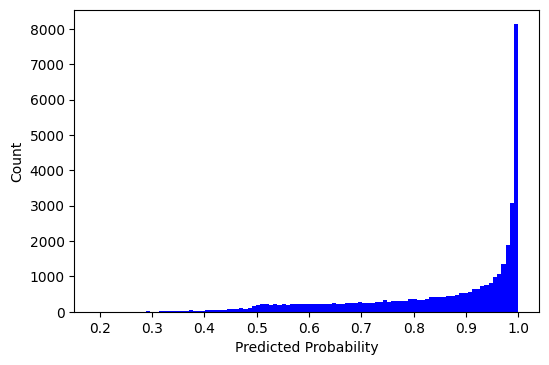

In [11]:
vals, idx = all_probs[~is_bg].max(dim=-1)
plt.hist(vals.numpy(), color='blue', bins=100, density=False);
plt.xlabel('Predicted Probability');
plt.ylabel('Count');

### For all boxes assigned to non-background, what is the histogram of the probability of the correct class?

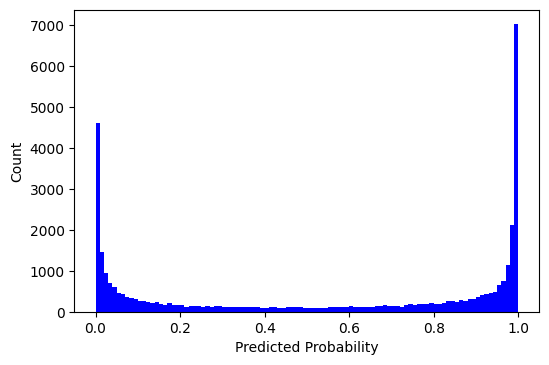

In [12]:
plt.hist(corr_probs[~is_bg].numpy(), color='blue', bins=100, density=False);
plt.xlabel('Predicted Probability');
plt.ylabel('Count');

### For all boxes assigned to background, what is the histogram of the probability of the most likely class?

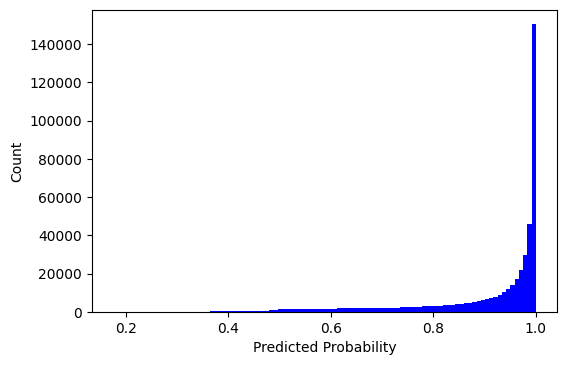

In [13]:
vals, idx = all_probs[is_bg].max(dim=-1)
plt.hist(vals.numpy(), color='blue', bins=100, density=False);
plt.xlabel('Predicted Probability');
plt.ylabel('Count');

### For all boxes assigned to background, what is the histogram of the probability of the correct class?

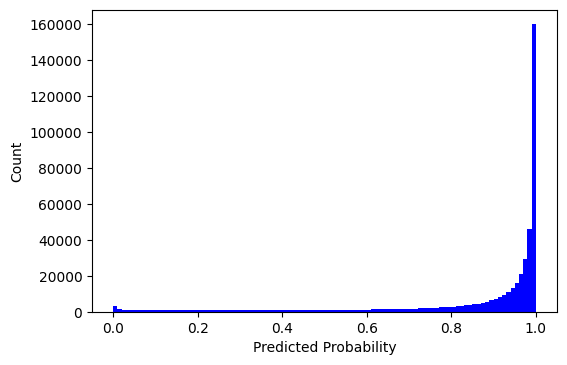

In [14]:
vals, idx = all_probs[is_bg].max(dim=-1)
plt.hist(corr_probs[is_bg].numpy(), color='blue', bins=100, density=False);
plt.xlabel('Predicted Probability');
plt.ylabel('Count');